# 信用情報

## 【問題1】コンペティション内容の確認


### 何を学習し、何を予測するのか

約１２０項目、約３０万件の顧客データを学習し、<br>
新たな顧客が、デフォルトする確率を予測する。

### どのようなファイルを作りKaggleに提出するか

テストデータの全ての顧客IDに対して、デフォルトする確率をつけて提出する

### 提出されたものはどういった指標値で評価されるのか

グラフに<br>
縦軸にTPR(正解Pの数に対して、Pと予測してPだったものの数の比)<br>
横軸にFPR(正解Nの数に対して、Pと予測してNだったものの数の比)<br>
をとる。<br>
ROC曲線(あるしきい値でのTPRとFPRの値を結んだもの)の下に広がる、<br>
面積AUC(Area Under Curve)が大きいほど良いとされる。

# ベースラインモデルの作成

## 【問題2】学習と検証

### week3の課題から分析した値を持ってくる

0    282686
1     24825
Name: TARGET, dtype: int64


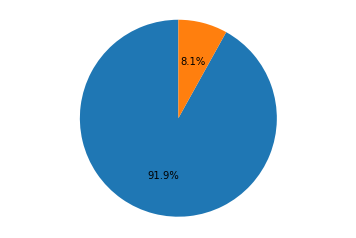

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


df = pd.read_csv("application_train2.csv")


column_null = df.isnull().sum()

#クラス毎のデータ数
target_count = df["TARGET"].value_counts()
print(target_count)


plt.pie(target_count, startangle=90, autopct="%1.1f%%")
plt.axis('equal')
plt.show()

# デフォルトした人のデータを取り出してみる
target1 = df[df.TARGET == 1]
target0 = df[df.TARGET == 0]

# 欠損率をみる
target1_missing_ratio = target1.isnull().sum() / 24825 * 100
target0_missing_ratio = target0.isnull().sum() / 282686 * 100

# 欠損率の　デフォルト　ー　返済した人

missing_ratio_gap = target1_missing_ratio - target0_missing_ratio

# 欠損率の差が０でない値を取り出す
#(~~~MODE,MEDI,AVGは扱いがわからないが欠損していることに意味があるかも)

missing_ratio_gap_not0 = missing_ratio_gap[missing_ratio_gap != 0].sort_values(ascending=False)
missing_ratio_gap_not0[30:70]

# AMT_REQ_CREDIT_BUREAU_YEAR, OWN_CAR_AGE, 
# OCCUPATION_TYPE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE
#あたりが気になる

#文字データの列を取り出す
df_str = df.select_dtypes(include=object)

# 数字データの列を取り出す
df_number = df.select_dtypes(include='number')

# 数値データから〜〜〜MODE,MEDI,AVGを消す
temp = pd.Series(df_number.columns.values)

mode = temp[temp.str.contains('MODE')]
medi = temp[temp.str.contains('MEDI')]
avg = temp[temp.str.contains('AVG')]

delete_clumns = pd.concat([mode, medi, avg])

df_number_delete_MODE = df_number.drop(delete_clumns, axis=1)

#データまとめ

# 人数
number_people0 = 282686
number_people1 = 24825

#全体
df

#デフォルトしたか、しないか
target1 = df[df.TARGET == 1]
target0 = df[df.TARGET == 0]

#数値データの列
df_number = df.select_dtypes(include='number')
#数値データの中から~~~MODE,MEDI,AVGを除外したもの
df_number_delete_MODE

#文字データの列
df_str = df.select_dtypes(include=object)

#数値データの中でデフォルトしたか
target1_number = df_number[df_number.TARGET == 1]
target0_number = df_number[df_number.TARGET == 0]

#文字データの中でデフォルトしたか
target1_str = target1.select_dtypes(include=object)
target0_str = target0.select_dtypes(include=object)

# 数値データの相関係数
df_number_corr = df_number.corr()
corr_about_target = df_number_corr.TARGET.sort_values(ascending=False)

#全ての文字データの数値化に挑戦してみる
temp = pd.Series(df_str.columns.values)
df_str_count = {}
df_str_label_number = {}
for i in temp:
    vc = df_str[i].value_counts()
    #print(vc)
    df_str_count[i] = vc
#print(df_str_count)

#辞書内のリストのキーを辞書化し、０、１とナンバリング
for j in df_str_count.keys():
    df_str_count[j]
    count = 0
    for key in df_str_count[j].keys():
        if key not in df_str_label_number:
            df_str_label_number[key] = count
            count += 1

#値を置き換え
df_str_number = df_str.replace(df_str_label_number)


#文字データの項目のナンバリングに成功
#ただ、この方法では、no,yesなどの、かぶった項目をユニークなものとしていない
#また、出現した順に数字を振るので、順序がある項目に順序をつけられない方法である

#TARGETと結合
df_str_numbers = pd.concat([df_str_number,df["TARGET"]], axis=1)

### 欠損率が高いのはデフォルトした人ではないか
### 欠損値からは
#AMT_REQ_CREDIT_BUREAU_YEAR, OWN_CAR_AGE, OCCUPATION_TYPE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE
### 相関係数が高いものは、
#DAYS_BIRTH, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH , REG_CITY_NOT_WORK_CITY
### 相関係数が低いものは、
#DAYS_EMPLOYED, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, AMT_CREDIT, HOUR_APPR_PROCESS_START

In [2]:
#文字データの数値化を関数化
#文字データ数値データが混在したものを引数とする
#文字データの列を自動で取り出し、数値化
#数値データと文字データを数値化したものを戻す

def convert_str(df):
    df_str = df.select_dtypes(include=object)
    df_number = df.select_dtypes(include='number')
    temp = pd.Series(df_str.columns.values)
    df_str_count = {}
    df_str_label_number = {}
    for i in temp:
        vc = df_str[i].value_counts()
        #print(vc)
        df_str_count[i] = vc
    #print(df_str_count)

    #辞書内のリストのキーを辞書化し、０、１とナンバリング
    for j in df_str_count.keys():
        df_str_count[j]
        count = 0
        for key in df_str_count[j].keys():
            if key not in df_str_label_number:
                df_str_label_number[key] = count
                count += 1

    #値を置き換え
    df_str_to_number = df_str.replace(df_str_label_number)
    
    return df_str_to_number,df_number

### 訓練用データと検証用データの分割

In [3]:
df_number_strnumber = pd.concat([df_str_number,df_number], axis=1)
df_columns = df_number_strnumber.columns

# 欠損データは列毎の最頻値で埋める
df_delete_nan = df_number_strnumber.fillna(df_number_strnumber.mode().iloc[0])

df_delete_nan.isnull().sum().sum()

0

In [4]:
df_delete_nan_X = df_delete_nan.drop(["TARGET"],axis=1)

X, y  = np.array(df_delete_nan_X), np.array(df_delete_nan["TARGET"])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

# データの標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
#決定木
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)


from sklearn.metrics import (roc_curve, auc, accuracy_score)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)

0.8508202851893404

In [7]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)

/Users/takamoriyuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.920231533421134

In [8]:
submission = clf.predict_proba(X_train_std)
submission

array([[0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ],
       ...,
       [0.4, 0.6],
       [0.5, 0.5],
       [1. , 0. ]])

In [9]:
auc(fpr, tpr)

0.504916981679262

### scikit-learnを使い4種類の指標を計算する

In [10]:
#正解率 (Accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.920231533421134

In [11]:
#精度 (Precision)
from sklearn.metrics import precision_score
precision_score(y_test, pred)

0.34545454545454546

In [12]:
#検出率 (Recall)
from sklearn.metrics import recall_score
recall_score(y_test, pred)

0.011740473738414007

In [13]:
# F 値
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.022709163346613544

In [14]:
# 混同行列
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[56540,   108],
       [ 4798,    57]])

## 【問題3】テストデータに対する推定


### テストデータの加工

In [15]:
testdf = pd.read_csv("application_test2.csv")

# 数値データを取り出す
testdf_number = testdf.select_dtypes(include='number')
#文字データの列を取り出す
testdf_str = testdf.select_dtypes(include=object)

#全ての文字データの数値化に挑戦してみる
temp = pd.Series(testdf_str.columns.values)
testdf_str_count = {}
testdf_str_label_number = {}
for i in temp:
    vc = testdf_str[i].value_counts()
    #print(vc)
    testdf_str_count[i] = vc
#print(df_str_count)

#辞書内のリストのキーを辞書化し、０、１とナンバリング
for j in testdf_str_count.keys():
    testdf_str_count[j]
    count = 0
    for key in testdf_str_count[j].keys():
        if key not in testdf_str_label_number:
            testdf_str_label_number[key] = count
            count += 1

#値を置き換え
testdf_str_number = testdf_str.replace(testdf_str_label_number)
#文字データの項目のナンバリングに成功

testdf_number_strnumber = pd.concat([testdf_str_number,testdf_number], axis=1)

# 欠損データは列毎の最頻値で埋める
testdf_delete_nan = testdf_number_strnumber.fillna(testdf_number_strnumber.mode().iloc[0])


In [16]:
# データの標準化処理
sc = StandardScaler()
sc.fit(testdf_delete_nan)
testdf_std = sc.transform(testdf_delete_nan)

In [17]:
#fit
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
testpred = clf.predict(testdf_std)


### テストデータに対する確率の出力

In [18]:
submission1 = clf.predict_proba(testdf_std)
submission1


array([[0.9, 0.1],
       [0.6, 0.4],
       [1. , 0. ],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [0.7, 0.3]])

### 提出ファイルの作成

In [19]:
list1 =[0, "TARGET"]

submission1_df = pd.DataFrame(submission1,columns=list1)
submission_file = pd.concat([testdf["SK_ID_CURR"], submission1_df["TARGET"]], axis=1) 



In [20]:
submission_file.to_csv("kaggle_homecredit1", index=False)

# 特徴量エンジニアリング


## 【問題4】特徴量エンジニアリング(最低5パターン)


### 気になる特徴量だけで学習

### 気になる特徴量
- 欠損値からは
- AMT_REQ_CREDIT_BUREAU_YEAR, OWN_CAR_AGE, OCCUPATION_TYPE, - ----OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE
- 相関係数が高いものは、
- DAYS_BIRTH, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH , REG_CITY_NOT_WORK_CITY
- 相関係数が低いものは、
- DAYS_EMPLOYED, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, AMT_CREDIT, HOUR_APPR_PROCESS_START
- 若い人の特徴からは
- DAYS_BIRTH,FLAG_EMP_PHONE,DAYS_EMPLOYED,EXT_SOURCE_1, FLAG_DOCUMENT_6,EXT_SOURCE_3,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_YEAR

### パターン１：気になる特徴量

AMT_REQ_CREDIT_BUREAU_YEAR,
OWN_CAR_AGE, OCCUPATION_TYPE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLEDAYS_BIRTH, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, DAYS_LAST_PHONE_CHANGE, DAYS_ID_PUBLISH , REG_CITY_NOT_WORK_CITYDAYS_EMPLOYED, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, AMT_CREDIT, HOUR_APPR_PROCESS_STARTDAYS_BIRTH,FLAG_EMP_PHONE,DAYS_EMPLOYED,EXT_SOURCE_1, FLAG_DOCUMENT_6,EXT_SOURCE_3,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER

In [21]:
moji = "AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE,OCCUPATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AMT_CREDIT,HOUR_APPR_PROCESS_START,DAYS_BIRTH,FLAG_EMP_PHONE,DAYS_EMPLOYED,EXT_SOURCE_1,FLAG_DOCUMENT_6,EXT_SOURCE_3,EXT_SOURCE_2,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER"

moji_list = moji.split(',')

moji_list

['AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_BIRTH',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT',
 'HOUR_APPR_PROCESS_START',
 'DAYS_BIRTH',
 'FLAG_EMP_PHONE',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'FLAG_DOCUMENT_6',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CODE_GENDER']

In [22]:
#moji_listの列だけ抽出
df_delete_nan1 = df_delete_nan.loc[:, moji_list]

X, y  = np.array(df_delete_nan1), np.array(df["TARGET"])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

# データの標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#決定木
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)


from sklearn.metrics import (roc_curve, auc, accuracy_score)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)

0.9194185649480513

In [24]:
auc(fpr, tpr)

0.509466149096282

In [25]:
"""
# Feature Importance
fti = clf.feature_importances_   

feature_importances_dict = {}
for i, feat in enumerate(testdf_delete_nan.columns):
    feature_importances_dict[feat] =  fti[i]
    
#a = pd.DataFrame.from_dict(feature_importances_dict)
feature_importances_list = sorted(feature_importances_dict.items(), key=lambda x:x[1])
feature_importances_df = pd.Series(feature_importances_list)
"""

'\n# Feature Importance\nfti = clf.feature_importances_   \n\nfeature_importances_dict = {}\nfor i, feat in enumerate(testdf_delete_nan.columns):\n    feature_importances_dict[feat] =  fti[i]\n    \n#a = pd.DataFrame.from_dict(feature_importances_dict)\nfeature_importances_list = sorted(feature_importances_dict.items(), key=lambda x:x[1])\nfeature_importances_df = pd.Series(feature_importances_list)\n'

#### 提出するために、テストデータを加工して予測

In [26]:
testdf_delete_nan1 = testdf_delete_nan.loc[:, moji_list]


# データの標準化処理
sc = StandardScaler()
sc.fit(testdf_delete_nan1)
testdf_std = sc.transform(testdf_delete_nan1)

In [27]:
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
testpred = clf.predict(testdf_std)

In [28]:
submission2 = clf.predict_proba(testdf_std)
submission2

array([[0.8, 0.2],
       [0.7, 0.3],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [0.7, 0.3]])

In [29]:
list2 =[0, "TARGET"]

submission2_df = pd.DataFrame(submission2,columns=list1)
submission_file2 = pd.concat([testdf["SK_ID_CURR"], submission2_df["TARGET"]], axis=1) 



submission_file2.to_csv("kaggle_homecredit2", index=False)

### パターン２<br>
- 正答に寄与した特徴量だけ抜き出してみる


In [30]:
feature_str = "EXT_SOURCE_2,EXT_SOURCE_3,DAYS_ID_PUBLISH,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,EXT_SOURCE_1,HOUR_APPR_PROCESS_START"


moji_list2 = feature_str.split(',')

moji_list2

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'DAYS_EMPLOYED',
 'REGION_POPULATION_RELATIVE',
 'AMT_GOODS_PRICE',
 'EXT_SOURCE_1',
 'HOUR_APPR_PROCESS_START']

In [31]:
df_delete_nan1 = df_delete_nan.loc[:, moji_list2]

df_delete_nan1.isnull().sum()

X, y  = np.array(df_delete_nan1), np.array(df["TARGET"])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)

# データの標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#決定木
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)


from sklearn.metrics import (roc_curve, auc, accuracy_score)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
pred = clf.predict(X_test_std)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)



0.9190933775588183

In [32]:
auc(fpr, tpr)

0.5098545814061826

#### 提出するために、テストデータを加工して予測

In [33]:
testdf_delete_nan2 = testdf_delete_nan.loc[:, moji_list2]


# データの標準化処理
sc = StandardScaler()
sc.fit(testdf_delete_nan2)
testdf_std = sc.transform(testdf_delete_nan2)

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train_std, y_train)
testpred = clf.predict(testdf_std)

submission3 = clf.predict_proba(testdf_std)
submission3

list3 =[0, "TARGET"]

submission3_df = pd.DataFrame(submission3,columns=list3)
submission_file3 = pd.concat([testdf["SK_ID_CURR"], submission3_df["TARGET"]], axis=1) 



submission_file3.to_csv("kaggle_homecredit3", index=False)

### パターン３:行ごとに欠損している項目数を特徴量として加えてみる

In [34]:
# テストデータと訓練データを同時に処理する
total_df = pd.concat([df,testdf],axis=0)#欠損あり

count_missing = total_df.isnull().sum(axis = 1)#欠損の数を数える
count_missing = pd.DataFrame(count_missing,columns=["COUNT_MISSING"])

total_df_missing = pd.concat([total_df,count_missing],axis=1)#特徴量追加

# NANを埋める
total_df_missing_delete_nan = total_df_missing.fillna(total_df_missing.mode().iloc[0])


/Users/takamoriyuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [35]:
moji_list.extend(["COUNT_MISSING","TARGET","SK_ID_CURR"])

In [36]:
#パターン１にCOUNT_MISSINGを加えたもの
total_df_mojilist = total_df_missing_delete_nan[moji_list]

In [37]:
#文字データの数値化
df_mojilist_str, df_mojilist_number= convert_str(total_df_mojilist)

In [38]:
total_df_mojilist = pd.concat([df_mojilist_str,df_mojilist_number],axis = 1)

In [39]:
train_total_df_mojilist = total_df_mojilist[total_df_mojilist["SK_ID_CURR"].isin(df["SK_ID_CURR"])]


In [40]:
test_total_df_mojilist = total_df_mojilist[total_df_mojilist["SK_ID_CURR"].isin(testdf["SK_ID_CURR"])]

In [41]:
#テストと訓練用に分ける

X, y  = np.array(train_total_df_mojilist), np.array(df["TARGET"])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)



from sklearn.metrics import (roc_curve, auc, accuracy_score)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, y_test)



1.0

In [42]:
auc(fpr, tpr)

1.0

In [43]:


clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)
testpred = clf.predict(test_total_df_mojilist)

submission4 = clf.predict_proba(test_total_df_mojilist)
submission4

list4 =[0, "TARGET"]

submission4_df = pd.DataFrame(submission3,columns=list4)
submission_file4 = pd.concat([testdf["SK_ID_CURR"], submission4_df["TARGET"]], axis=1) 



submission_file4.to_csv("kaggle_homecredit7", index=False)

In [44]:
#欠損している項目量を特徴量にするとaucが１になってしまった。

### パターン４：欠損率を加えてデータ全体で学習する

In [45]:
# テストデータと訓練データを同時に処理する
total_df = pd.concat([df,testdf],axis=0)#欠損あり

count_missing = total_df.isnull().sum(axis = 1)#欠損の数を数える
count_missing = pd.DataFrame(count_missing / 122,columns=["COUNT_MISSING"])

total_df_missing = pd.concat([total_df,count_missing],axis=1)#特徴量追加

# NANを埋める
total_df_missing_delete_nan = total_df_missing.fillna(total_df_missing.mode().iloc[0])


#文字データの数値化
df_missing_str, df_missing_number= convert_str(total_df_missing_delete_nan)

total_df_missing = pd.concat([df_missing_str,df_missing_number],axis = 1)



/Users/takamoriyuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [46]:
train_total_df_missing = total_df_missing[total_df_missing["SK_ID_CURR"].isin(df["SK_ID_CURR"])]


In [47]:
test_total_df_missing = total_df_missing[total_df_missing["SK_ID_CURR"].isin(testdf["SK_ID_CURR"])]

In [48]:
#訓練データとテストデータを分け学習し、提出ファイルを作るところまでを関数化する   

def clf_train(traindata,testdata):
    #テストと訓練用に分ける
    X, y  = np.array(traindata), np.array(df["TARGET"])

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler 

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0)

    from sklearn.metrics import (roc_curve, auc, accuracy_score)

    #ランダムフォレスト
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label=1)
    auc(fpr, tpr)
    accuracy_score(pred, y_test)

    # テストデータ
    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X_train, y_train)
    testpred = clf.predict(testdata)
    submission5 = clf.predict_proba(testdata)

    list4 =[0, "TARGET"]

    submission4_df = pd.DataFrame(submission5,columns=list4)
    submission_file4 = pd.concat([testdf["SK_ID_CURR"], submission4_df["TARGET"]], axis=1) 

    return auc(fpr, tpr), accuracy_score(pred, y_test), submission_file4

#submission_file4.to_csv("kaggle_homecredit", index=False)

In [49]:
auc, accuracy, submission_file8 = clf_train(train_total_df_missing,test_total_df_missing)

In [50]:
accuracy

0.999154512787994

In [52]:
auc

0.9946446961894954

In [51]:
submission_file8.to_csv("kaggle_homecredit8", index=False)

### パターン５：train_test_splitをやめて、出来るだけ多くのデータで学習する

In [54]:
#訓練データとテストデータを分け学習し、提出ファイルを作るところまでを関数化する   

def clf_train２(traindata,testdata):
    #テストと訓練用に分ける
    X, y  = np.array(traindata), np.array(df["TARGET"])

    from sklearn.metrics import (roc_curve, auc, accuracy_score)

    #ランダムフォレスト
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(random_state=0)
    clf = clf.fit(X, y)
    
    # テストデータ
    testpred = clf.predict(testdata)
    submission5 = clf.predict_proba(testdata)

    list4 =[0, "TARGET"]

    submission4_df = pd.DataFrame(submission5,columns=list4)
    submission_file4 = pd.concat([testdf["SK_ID_CURR"], submission4_df["TARGET"]], axis=1) 

    return submission_file4

#submission_file4.to_csv("kaggle_homecredit", index=False)

In [55]:
submission_file9 = clf_train2(train_total_df_missing,test_total_df_missing)

In [56]:
submission_file9.to_csv("kaggle_homecredit9", index=False)

In [1]:
# 結果はパターン３:行ごとに欠損している項目数を特徴量として加えてみる,が一番良かった。
#private,0.61475
#public,0.60573
#であった。